# Exploring the world of audio augmentations and trasformations

If you want to use librosa trasformations in the training, remeber to add them inside a function that randomizes them.

Useful links:

https://pytorch.org/audio/stable/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py

Summary:

* 1D:
     - use audiomentations as they are already well implemented to be random and all    
     - Librosa has nice effects, but if we want to use them we should create functions that take care of randomizing them

* 2D:
    - use torchaudio library. It requires a different preprocessing of the audio. See below for details (post scriptum: non mi pare sia così diverso questo preprocessing actually...)
    - There is something wrong with our MELs.


After this exploration it remains to do:

1. Understanding MEL, (STFT and MFCC). MEL doesn't work properly
2. Deciding which transformations to use. I suggest to run benchmarks first, without any trans, then try with different trans and see what happens.
3. Normalization! What to use? What to do? MinMax? StandardScaler? What? See notebook `usage.ipynb` in FMA repository, they use standardscaler. 

In [31]:
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from torchaudio.utils import download_asset
from mgr.utils_mgr import create_dataloaders
import torchaudio.transforms as T
import numpy as np
import torch
import torchaudio

In [32]:
net_type = "1D"
batch_size = 64
num_workers = 4
transforms = None

train_dataloader, val_dataloader, test_dataloader = create_dataloaders(transforms=transforms, net_type=net_type,batch_size=batch_size,num_workers=num_workers)


/home/diego/miniconda3/envs/fma/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/diego/miniconda3/envs/fma/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [33]:
x = train_dataloader.dataset[1000][0]

## Listen to audio and play with trasformations

In [34]:
from IPython.display import Audio
import numpy as np

# Assuming `audio_array` is your audio array
# audio_array = ...

# Specify the sampling rate
sample_rate = 44100  # Adjust according to your audio data

# Convert the audio array to a numpy array (if it's not already)
audio_np = np.array(x)

# Display the audio
Audio(data=audio_np, rate=sample_rate)


In [35]:
Audio(librosa.effects.harmonic(x), rate=44100)

In [36]:
Audio(librosa.effects.percussive(x), rate=44100)

Stretched makes clip last shorter. Add silence to obviate this.

In [37]:
stretched = librosa.effects.time_stretch(x, rate=1.2)

In [38]:
stretched.shape

(1, 218453)

In [39]:
x.shape[1]

262144

In [40]:
# Zeros to append --> silence
zero_vector = np.zeros(shape=(1,x.shape[1] - stretched.shape[1]))
zero_vector.shape

(1, 43691)

In [41]:
stretched.shape

(1, 218453)

In [42]:
zero_vector.shape

(1, 43691)

In [43]:
np.concatenate((stretched, zero_vector),axis=1).shape

(1, 262144)

In [44]:
Audio(np.concatenate((stretched, zero_vector),axis=1), rate=44100)

In [45]:
Audio(librosa.effects.time_stretch(x, rate=1.2), rate=44100)

In [46]:
Audio(librosa.effects.pitch_shift(x, sr=44100, n_steps=-5), rate=44100)

In [47]:
Audio(librosa.effects.preemphasis(x, coef=.97), rate=44100)

### Adding noise

In [48]:
import numpy as np

# Set the mean and standard deviation of the Gaussian distribution
mean = 0
std = 1

# Generate a random sample from the Gaussian distribution with the same shape as x
sample = np.random.normal(mean, std, size=x.shape)

sample.shape


(1, 262144)

In [49]:
Audio(x + sample, rate=44100)

In [50]:
Audio(x+.1*sample, rate=44100)

## Using audiomentations

In [51]:
import audiomentations as audio

train_audio_transform = audio.Compose([   
    # add gaussian noise to the samples
    audio.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    # change the speed or duration of the signal without changing the pitch
    audio.TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    # pitch shift the sound up or down without changing the tempo
    #audio.PitchShift(min_semitones=-4, max_semitones=4, p=0.5)
])

In [52]:
Audio(train_audio_transform(x, sample_rate=44100), rate=44100)

## 2D transforms

**WARNING**: why the fuck in github raggiungono quasi il 50% di accuracy usando una semplice SVC???????!!! Guarda notebook `usage.ipynb`


*Nota*: Here I'll be using torchaudio transformations. They require a different preprocessing of audio to get a spectrogram. I will begin showing how to obtain the correct pipeline to make torchaudio transformations work, and only eventually how to implement the new pipeline with our standard-librosa one.

In [53]:
# This is how we get the audio data in the dataset class

from mgr.utils_mgr import getAudio

audio, sr = getAudio(5)

#Select random clip from audio
start = np.random.randint(0, (audio.shape[0]-2**18))
audio = audio[start:start+2**18]
audio.shape


(262144,)

In [54]:
Audio(audio, rate=sr)

The first thing to do is to transform the waveform into a torch tensor object, and then add the channel information.
We could try to use dismiss the utils-way of importing audio, in favour of the torchaudio way of doing it.
For now I'm just trying to find a way to make transformations work with out data.

In [55]:
print("audio shape that we usually work with",audio.shape)
taudio = torch.Tensor(audio).unsqueeze(0)
print("if it were loaded with torchaudio",taudio.shape)

audio shape that we usually work with (262144,)
if it were loaded with torchaudio torch.Size([1, 262144])


### Stretching

In [56]:
# It is possible that our way of proceeding doesn't work because we're using a different n_fft value.
# What I'll try next is to make changes to the torchaudio spectrogram to see if we can get the same results as with librosa.

spectrogram = torchaudio.transforms.Spectrogram(power=None) 
stretch = torchaudio.transforms.TimeStretch()
original = spectrogram(taudio)
stretched_1_2 = stretch(original, 1.2)


print("original shape",original.shape)
print("stretched shape",stretched_1_2.shape)

original shape torch.Size([1, 201, 1311])
stretched shape torch.Size([1, 201, 1093])


In [57]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


You see that the clip lasts longer

/tmp/ipykernel_133552/623082153.py:21: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


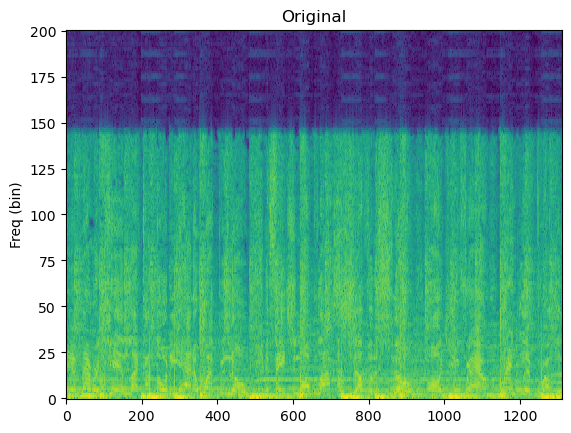

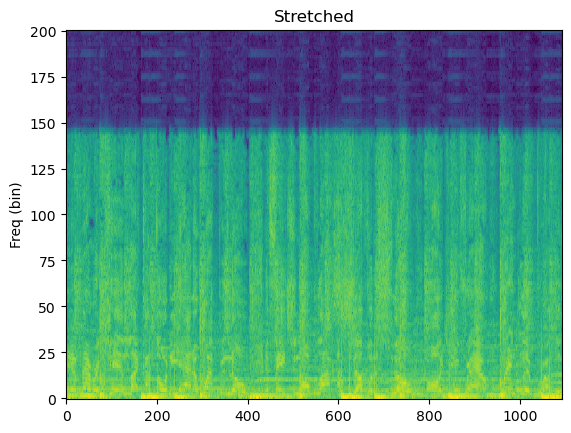

In [58]:
plot_spectrogram(original[0], title="Original", ylabel="Freq (bin)", ax=None)
plot_spectrogram(stretched_1_2[0], title="Stretched", ylabel="Freq (bin)", ax=None)

### Frequency Masking

In [76]:
masking = torchaudio.transforms.FrequencyMasking(freq_mask_param=100)
spec = torchaudio.transforms.Spectrogram() # If I set power to None, it will raise an error. To investigate.
original = spec(taudio)
masked = masking(original) 

It seems that event the original is kinda masked on the higher frequencies... 


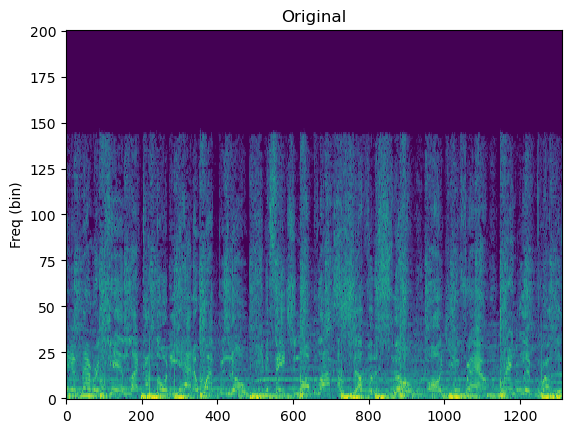

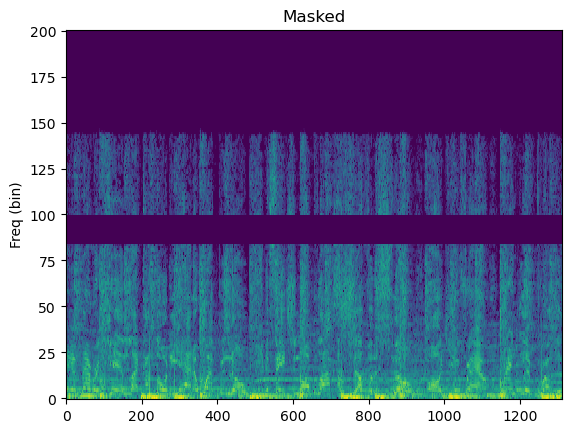

In [77]:
plot_spectrogram(original[0], title="Original", ylabel="Freq (bin)", ax=None)
plot_spectrogram(masked[0], title="Masked", ylabel="Freq (bin)", ax=None)

### Time Masking

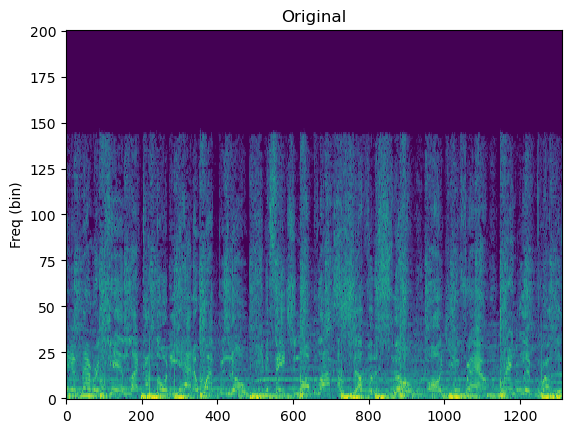

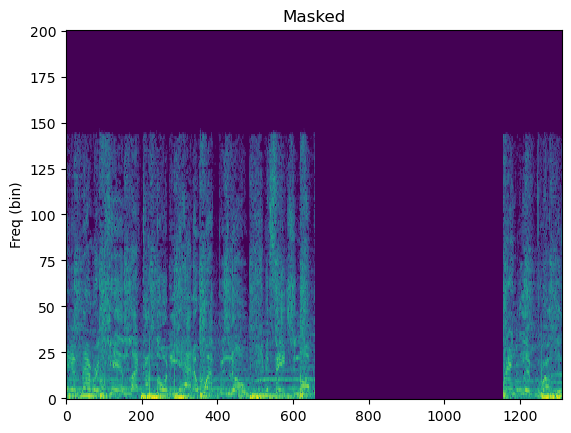

In [79]:
time_mask = torchaudio.transforms.TimeMasking(time_mask_param=500)
masked = time_mask(original)
plot_spectrogram(original[0], title="Original", ylabel="Freq (bin)", ax=None)
plot_spectrogram(masked[0], title="Masked", ylabel="Freq (bin)", ax=None)

### Does this work on MEL Spectrogams?

In [62]:
# These values are all taken as they come from the examples in the torchaudio documentation.
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128
sample_rate = 44100

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(taudio)
melspec.shape

/home/diego/miniconda3/envs/fma/lib/python3.10/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


torch.Size([1, 128, 513])

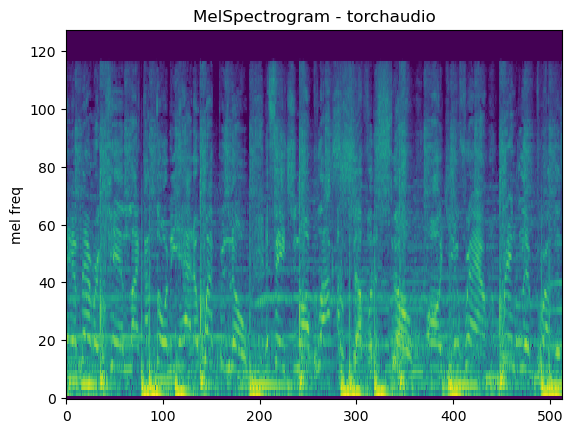

In [63]:
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

Running multiple times the length of the mask will change

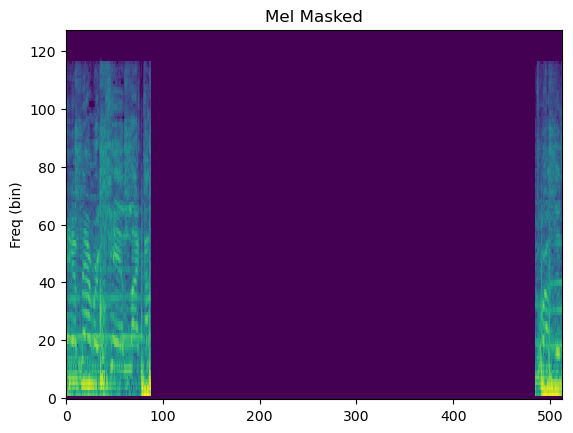

In [64]:
time_mask = torchaudio.transforms.TimeMasking(time_mask_param=500)
masked = time_mask(melspec)
plot_spectrogram(masked[0], title="Mel Masked", ylabel="Freq (bin)", ax=None)

## Torchaudio vs utils_mgr

In [65]:
# Melspec obtained with procedure above - Torchaudio
melspec.shape

torch.Size([1, 128, 513])

In [66]:
# Our mgr utils way of doing it would be so:

stft = np.abs(librosa.stft(audio, n_fft=4096, hop_length=2048))

mel = librosa.feature.melspectrogram(sr=sr, S=stft**2, n_mels=513)[:,:128]
mel = librosa.power_to_db(mel).T
mel.shape

(128, 513)

In [67]:
# Just convert it into tensor and add the channel dimension
tmel = torch.Tensor(mel).unsqueeze(0)
tmel.shape

torch.Size([1, 128, 513])

In [68]:
tmel[0].shape

torch.Size([128, 513])

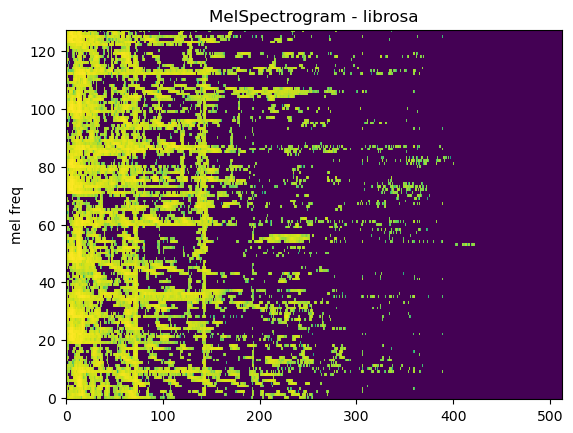

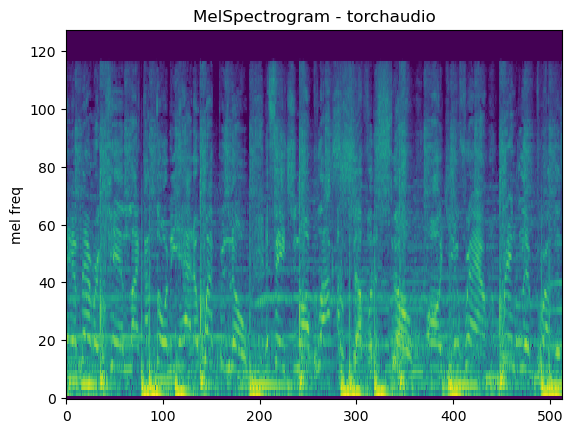

In [69]:
plot_spectrogram(tmel[0], title="MelSpectrogram - librosa", ylabel="mel freq")
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

Una bellissima opera d'arte.

Transformation doesn't raise error but there's something wrong with mel (independently of transformatio)

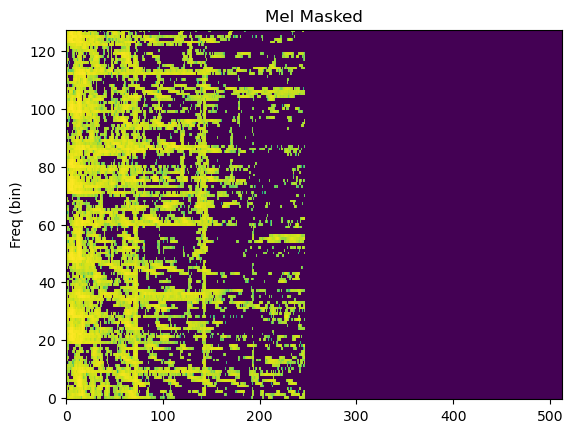

In [70]:
mel_masked = time_mask(tmel)
plot_spectrogram(mel_masked[0], title="Mel Masked", ylabel="Freq (bin)", ax=None)

Let's change the way we build the mel spectrogram

In [71]:
# Our mgr utils way of doing it would be so:

"""
n_fft = 4096 --> 1024
win_length = None
hop_length = 2048 --> 512
n_mels = 513 --> 128
sample_rate = 44100
"""

#stft = np.abs(librosa.stft(audio, n_fft=1024, hop_length=512))
stft = librosa.stft(audio, n_fft=1024, hop_length=512) # Removing np.abs

mel = librosa.feature.melspectrogram(sr=sr, S=stft**2, n_mels=128) # deleting this part [:,:128]
mel = librosa.power_to_db(mel)# .T  don't transpose
mel.shape

/tmp/ipykernel_133552/2023305971.py:15: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  mel = librosa.power_to_db(mel)# .T  don't transpose


(128, 513)

There is still something wrong with our mels.

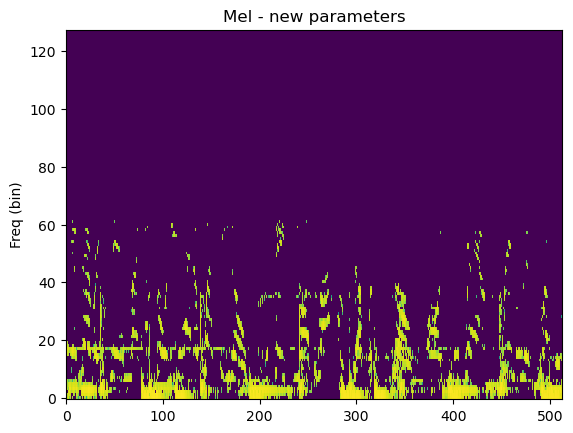

In [72]:
plot_spectrogram(mel, title="Mel - new parameters", ylabel="Freq (bin)", ax=None)

Last thing: does torchaudio work well?

## Importing audio with torchaudio

In [73]:
# It should work exactly like librosa.load but it also transforms into tensor

torchaudio.load("/home/diego/Music-Genre-Recognition/data/fma_small/000/000002.mp3")

(tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.2256, -0.1806, -0.0919],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.2690, -0.2172, -0.1184]]),
 44100)

Sarebbe da cambiare la funzione `getAudio`, ma in realtà non è necessario.